In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  
import seaborn as sns
import json

Best training accuracy: 1.0000 at k=1
Best validation accuracy: 0.8399 at k=9


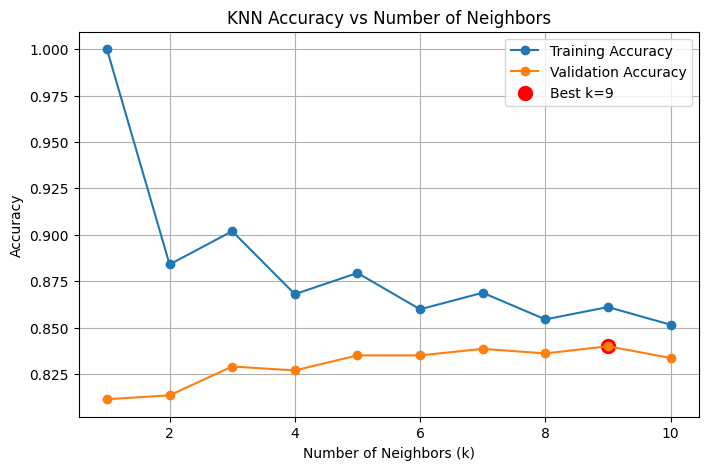

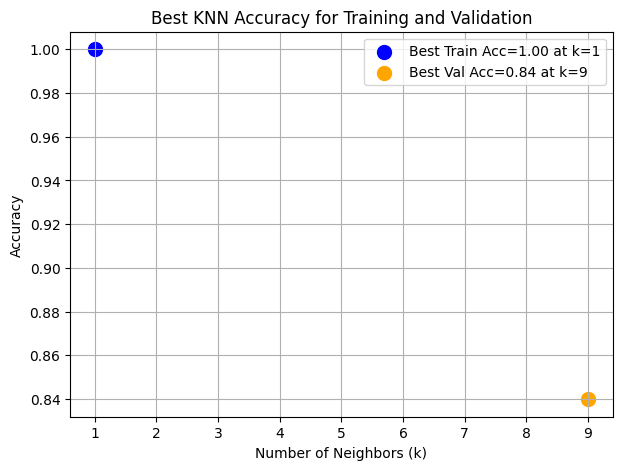


Final Model Performance:
Accuracy : 0.8367
Precision: 0.8472
Recall   : 0.8367
F1 Score : 0.8266


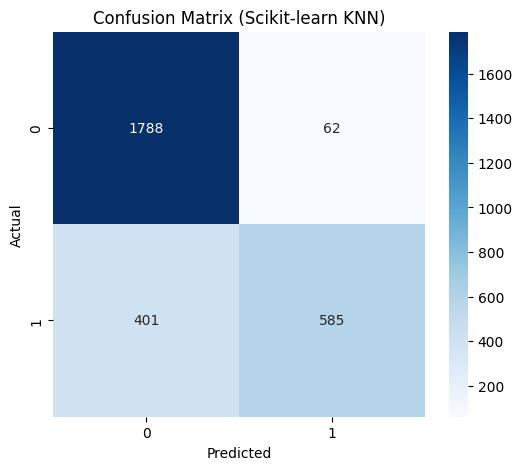

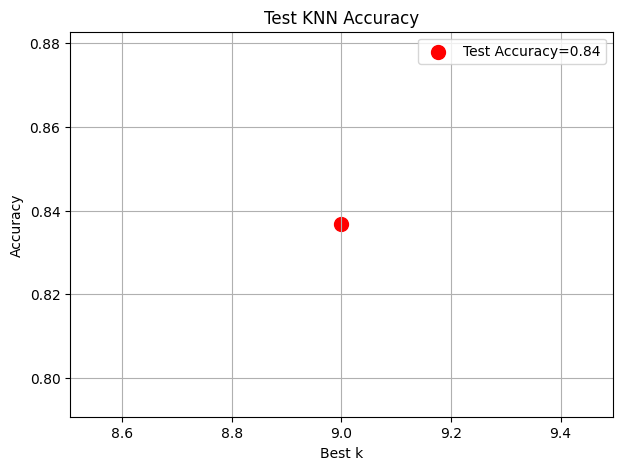

In [ ]:
Ks = range(1,11)
trn_acc = []
val_acc = []
bestk = 0
testAcc = 0.0

def remove_duplicates(dataset: pd.DataFrame):
    return dataset.drop_duplicates()

def remove_missing_targets(dataset: pd.DataFrame, target):
    return dataset.dropna(subset=[target])
    

def impute_missing_values(features: pd.DataFrame):
    for column in features.columns:
        features.fillna(features[column].mean(), inplace=True)
    return features


def feature_transformation(x_train, x_validation, x_test):
    # Robust transform (value - median) / IQR
    scaler = RobustScaler()

    x_train_scaled = scaler.fit_transform(x_train)
    x_validation_scaled = scaler.transform(x_validation)
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, x_validation_scaled, x_test_scaled

def data_preprocessing(dataset: pd.DataFrame):

    dataset.drop('Unnamed: 0', axis=1, inplace=True)
    dataset = remove_duplicates(dataset)

    target = 'class'
    dataset = remove_missing_targets(dataset, target)

    X = dataset.drop(target, axis=1)
    y = dataset[target]

    X = impute_missing_values(X)

    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    x_test, x_validation, y_test, y_validation = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    
    x_train, x_validation, x_test = feature_transformation(x_train, x_validation, x_test)

    return x_train, y_train, x_validation, y_validation, x_test, y_test

def knn_classifier(dataset: pd.DataFrame):

    global Ks, trn_acc, val_acc, bestk, testAcc

    x_train, y_train, x_validation, y_validation, x_test, y_test = data_preprocessing(dataset)

    training_accuracy = []
    validation_accuracy = []

    # Try different values for k
    k_neighbours = range(1, 11)
    for k in k_neighbours:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train, y_train)
        training_accuracy.append(model.score(x_train, y_train))
        validation_accuracy.append(model.score(x_validation, y_validation))

    validation_accuracy = np.array(validation_accuracy)

    best_k_train = np.argmax(training_accuracy) + 1
    best_acc_train = training_accuracy[best_k_train - 1]

    best_k_val = np.argmax(validation_accuracy) + 1
    best_acc_val = validation_accuracy[best_k_val - 1]

    print(f"Best training accuracy: {best_acc_train:.4f} at k={best_k_train}")
    print(f"Best validation accuracy: {best_acc_val:.4f} at k={best_k_val}")

    plt.figure(figsize=(8, 5))
    plt.plot(k_neighbours, training_accuracy, label="Training Accuracy", marker='o')
    plt.plot(k_neighbours, validation_accuracy, label="Validation Accuracy", marker='o')
    plt.scatter(best_k_val, validation_accuracy[best_k_val - 1], color='red', label=f"Best k={best_k_val}", s=100)
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title("KNN Accuracy vs Number of Neighbors")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot only best points
    plt.figure(figsize=(7, 5))
    plt.scatter(best_k_train, best_acc_train, color='blue', s=100, label=f"Best Train Acc={best_acc_train:.2f} at k={best_k_train}")
    plt.scatter(best_k_val, best_acc_val, color='orange', s=100, label=f"Best Val Acc={best_acc_val:.2f} at k={best_k_val}")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.title("Best KNN Accuracy for Training and Validation")
    plt.legend()
    plt.grid(True)
    plt.show()

    final_model = KNeighborsClassifier(n_neighbors=best_k_val)
    final_model.fit(x_train, y_train)
    test_pred = final_model.predict(x_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, average='weighted')
    recall = recall_score(y_test, test_pred, average='weighted')
    f1 = f1_score(y_test, test_pred, average='weighted')
    cm = confusion_matrix(y_test, test_pred)

    print("\nFinal Model Performance:")
    print(f"Accuracy : {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Scikit-learn KNN)')
    plt.show()

    # Plot test accuracy
    plt.figure(figsize=(7, 5))
    plt.scatter(best_k_val, test_accuracy, color='red', s=100, label=f"Test Accuracy={test_accuracy:.2f}")
    plt.xlabel("Best k")
    plt.ylabel("Accuracy")
    plt.title("Test KNN Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    trn_acc = training_accuracy
    val_acc = validation_accuracy
    bestk = best_k_val
    testAcc = test_accuracy

    return {
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm.tolist()
    }

dataset = pd.read_csv("telescope_data.csv")
metrics = knn_classifier(dataset)

results = {
        "k_values": list(Ks),
        "training_accuracy": list(trn_acc),
        "validation_accuracy": list(val_acc),
        "best_k": int(bestk),
        "best_val_accuracy": float(testAcc)
}

with open("results_model_without_scikit.json", "w") as f:
        json.dump(results, f, indent=4)